# modelling sea level from temperature

we have 2 data sets:
1. temperature data
2. sea level data

we have a model defined as 

$$
    \begin{align*}
    S_{eq} &= aT+b \\ 
    \frac{\partial S_{eq}}{\partial t} &= \frac{S-S_{eq}}{\tau}
    \end{align*}
$$

---

We want to predict the sea level from temperature such that it is consistent with the measured sea level data.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import theano
import theano.tensor as tt


In [17]:
df_T_forecast = pd.read_csv('data/T_forecast_auto_arima.csv', index_col=0)
# load data

df_T = pd.read_csv('data/processed_temperature_data.csv', index_col=0)

df_S = pd.read_csv('data/processed_sea_level_data.csv', index_col=0)

# stack df_T with forecast
print('len of df_T', len(df_T))
print('len of df_T_forecast', len(df_T_forecast))
df_T = pd.concat([df_T, df_T_forecast])
df_T

len of df_T 175
len of df_T_forecast 100


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,Annual_uncertainty
1850.0,-0.675000,-0.333000,-0.591000,-0.589000,-0.509000,-0.344000,-0.160000,-0.208000,-0.385000,-0.533000,-0.283000,-0.404000,-0.418000,0.155349
1851.0,-0.201000,-0.469000,-0.646000,-0.542000,-0.198000,-0.137000,-0.097000,-0.102000,-0.091000,-0.008000,-0.082000,-0.228000,-0.233000,0.196316
1852.0,-0.375000,-0.477000,-0.560000,-0.585000,-0.127000,-0.084000,0.005000,-0.136000,-0.002000,-0.172000,-0.305000,0.065000,-0.229000,0.216206
1853.0,-0.233000,-0.404000,-0.280000,-0.386000,-0.268000,-0.142000,-0.083000,-0.057000,-0.250000,-0.392000,-0.411000,-0.337000,-0.270000,0.118765
1854.0,-0.381000,-0.361000,-0.243000,-0.334000,-0.289000,-0.299000,-0.179000,-0.239000,-0.217000,-0.095000,-0.410000,-0.450000,-0.292000,0.098235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120.0,1.651283,1.651867,1.652452,1.653036,1.653621,1.654205,1.654790,1.655374,1.655959,1.656543,1.657128,1.657712,1.654497,0.002018
2121.0,1.658297,1.658881,1.659466,1.660050,1.660635,1.661219,1.661803,1.662388,1.662972,1.663557,1.664141,1.664726,1.661511,0.002018
2122.0,1.665310,1.665895,1.666479,1.667064,1.667648,1.668233,1.668817,1.669402,1.669986,1.670571,1.671155,1.671740,1.668525,0.002018
2123.0,1.672324,1.672909,1.673493,1.674078,1.674662,1.675247,1.675831,1.676416,1.677000,1.677585,1.678169,1.678754,1.675539,0.002018


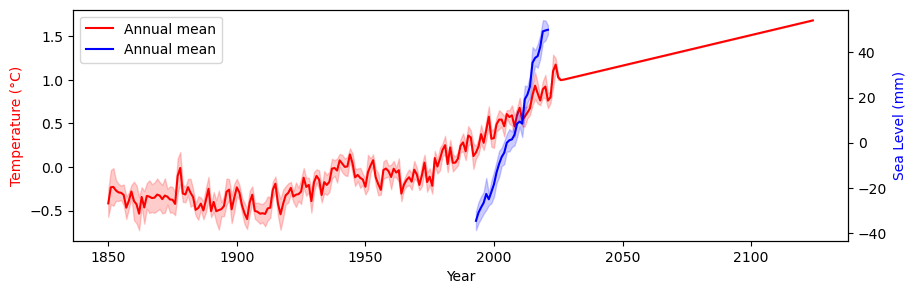

In [18]:

def plot_data(df_T, df_S):
    # plot data
    fig, ax = plt.subplots(figsize=(10, 3))
    ax2 = ax.twinx()

    # plt.plot(df_T.index, df_T['Annual'], label='Annual mean')
    # plt.plot(df_S.index, df_S['GMSL_noGIA'], label='Annual mean')
    ax.plot(df_T.index, df_T['Annual'], label='Annual mean', color='red')
    ax2.plot(df_S.index, df_S['GMSL_noGIA'], label='Annual mean', color='blue')

    # show uncertainty
    ax.fill_between(df_T.index, df_T['Annual'] - df_T['Annual_uncertainty'], df_T['Annual'] + df_T['Annual_uncertainty'], alpha=0.2, color='red')
    ax2.fill_between(df_S.index, df_S['GMSL_noGIA'] - df_S['uncertainty'], df_S['GMSL_noGIA'] + df_S['uncertainty'], alpha=0.2, color='blue')

    # combine legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='best')

    # add ax labels
    ax.set_xlabel('Year')
    ax.set_ylabel('Temperature (°C)', color='red')
    ax2.set_ylabel('Sea Level (mm)', color='blue')

    plt.show()

plot_data(df_T, df_S)


# MCMC

Running burn-in...


100%|██████████| 10000/10000 [01:23<00:00, 120.20it/s]


Running production...


100%|██████████| 20000/20000 [02:46<00:00, 119.95it/s]


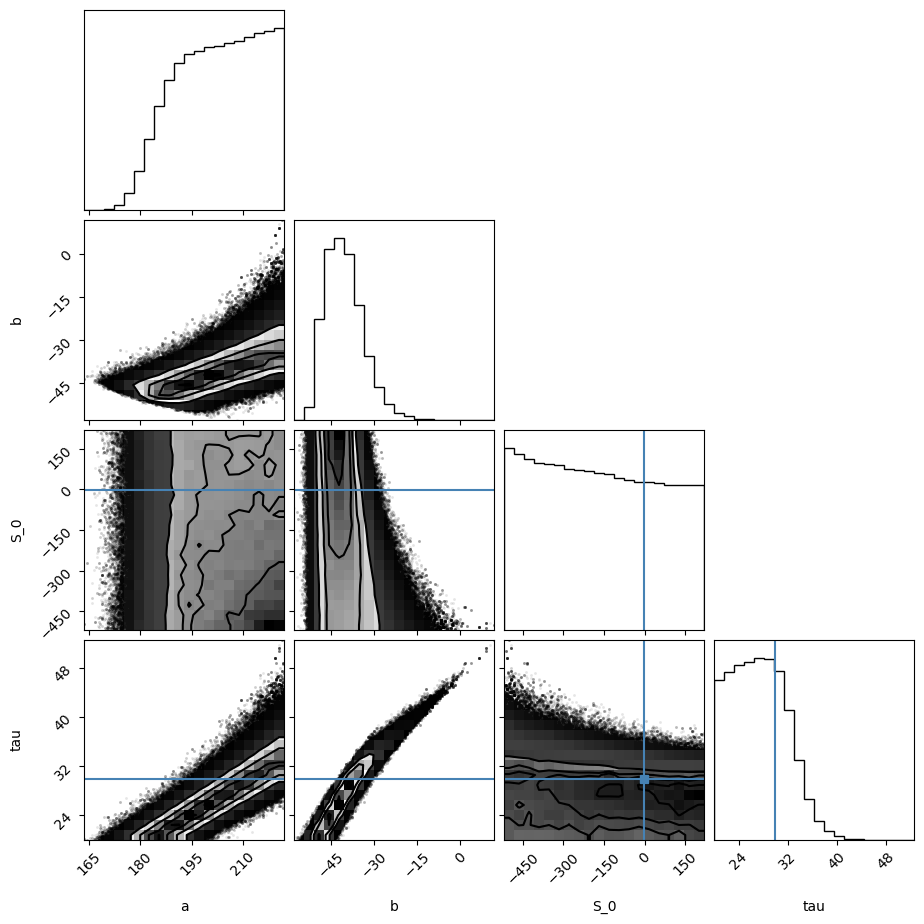

a = 203.507 (+12.778, -13.972)
b = -41.164 (+7.056, -5.839)
S_0 = -171.414 (+262.883, -243.084)
tau = 27.142 (+4.772, -4.729)


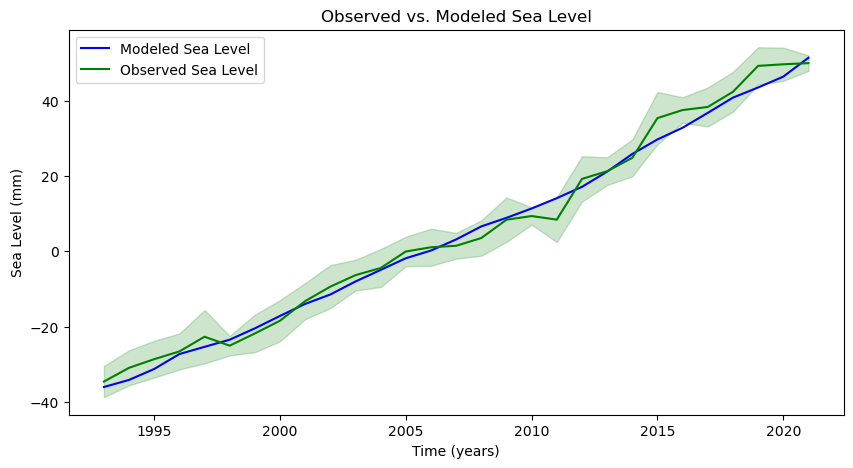

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner

# Assume df_T and df_S are your dataframes with temperature and sea level data
# df_T should have an index of time and a column 'Annual' for temperature anomalies
# df_S should have an index of time and columns 'GMSL_noGIA' for sea level and 'uncertainty' for measurement errors

# Extract time and temperature data
time = df_T.index.values
T = df_T['Annual'].values


# Observed sea level data and uncertainties
S_obs = df_S['GMSL_noGIA'].values #* 1e-3
sigma = df_S['uncertainty'].values #* 1e-3
offset = 100

# Define the model function
def get_S(T, a, b, S_0, tau, dt=1):
    # Calculate equilibrium sea level
    S_eq = a * T + b

    # Initialize S
    S = np.zeros(len(T))
    S[0] = S_0
    for i in range(1, len(T)):
        S[i] = S[i-1] + ((S_eq[i-1] - S[i-1]) / tau) * dt
    return S

# Define the log prior function
def log_prior(theta):
    a, b, S_0, tau = theta
    cond1 = 0 < a < 222
    cond2 = -200 < b < 522
    cond3 = -520 < S_0 < 220
    cond4 = 20 < tau < 60
    if cond1 and cond2 and cond3 and cond4:
        return 0.0  # Uniform prior (log probability is zero within bounds)
    return -np.inf  # Log probability is -infinity outside bounds

# Define the log likelihood function
def log_likelihood(theta, T, S_obs, sigma):
    a, b, S_0, tau = theta
    S_model = get_S(T, a, b, S_0, tau)
    # Align S_model and S_obs based on your original offset
      # Adjust this value if necessary
    S_model_aligned = S_model[-len(S_obs)-offset:-offset]
    # Compute the log likelihood assuming Gaussian errors
    return -0.5 * np.sum(((S_obs - S_model_aligned) / sigma)**2 + np.log(2 * np.pi * sigma**2))

# Define the full log probability function
def log_probability(theta, T, S_obs, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, T, S_obs, sigma)

# Initial guess for the parameters
initial = [115, 115, -1.00, 30.0]

# Set up the MCMC sampler
ndim = 4  # Number of parameters
nwalkers = 128  # Number of MCMC walkers
# Initialize the walkers in a small Gaussian ball around the initial guess
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Run MCMC using emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(T, S_obs, sigma))

# Burn-in phase
print("Running burn-in...")
sampler.run_mcmc(pos, 10000, progress=True)
sampler.reset()

# Production run
print("Running production...")
sampler.run_mcmc(None, 20000, progress=True)

# Extract the samples
samples = sampler.get_chain(flat=True)

# Plot posterior distributions
fig = corner.corner(samples, labels=["a", "b", "S_0", "tau"], truths=initial)
plt.show()

# Compute the mean and uncertainties of the parameters
from IPython.display import display, Math
import scipy.stats as stats

param_names = ["a", "b", "S_0", "tau"]
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{0} = {1:.3f} (+{2:.3f}, -{3:.3f})".format(param_names[i], mcmc[1], q[1], q[0])
    print(txt)

# Use the median parameters to compute the modeled sea level
best_params = np.median(samples, axis=0)
a_best, b_best, S_0_best, tau_best = best_params
S_model_full = get_S(T, a_best, b_best, S_0_best, tau_best)
S_model_aligned = S_model_full[-len(S_obs)-offset:-offset]

# Plot the observed vs. modeled sea level
plt.figure(figsize=(10, 5))
plt.plot(df_S.index, S_model_aligned, label='Modeled Sea Level', color='blue')
plt.plot(df_S.index, S_obs, label='Observed Sea Level', color='green')

plt.fill_between(df_S.index, S_obs - sigma, S_obs + sigma, color='green', alpha=0.2)
plt.xlabel('Time (years)')
plt.ylabel('Sea Level (mm)')
plt.title('Observed vs. Modeled Sea Level')
plt.legend()
plt.show()

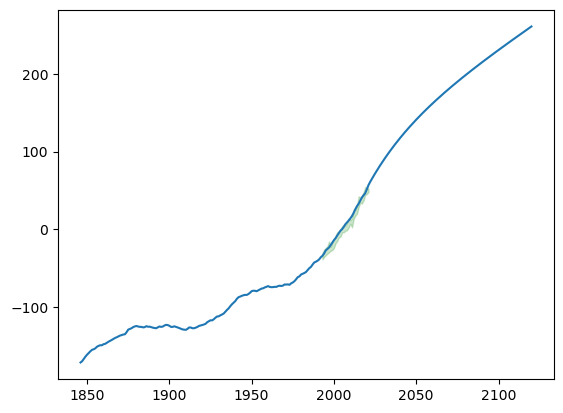

In [38]:
index_full = np.arange(2121-275, 2121)

plt.plot(index_full, S_model_full)
plt.fill_between(df_S.index, S_obs - sigma, S_obs + sigma, color='green', alpha=0.2)

In [36]:
df_S.index

Index([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021],
      dtype='int64', name='Year')

array([1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856,
       1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867,
       1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878,
       1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889,
       1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900,
       1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911,
       1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922,
       1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944,
       1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955,
       1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966,
       1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
       1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
       1989, 1990, 1991, 1992, 1993, 1994, 1995, 19